**Data Preprocessing**

This notebook is the second of five notebooks containing the central work for the project.

This notebook contains two pipelines that preprocess the data. The first pipleline includes data understanding, validation and EDA. The second pipeline includes data manipulation for cleaning purposes and preparation methods for the model building.


In [ ]:
# Gooogle Drive connection to your compute instance
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Start

In [ ]:
# Imports
import pandas as pd
from tqdm.notebook import trange, tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import scipy
from scipy.stats import pearsonr
import pickle


from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

from pathlib import Path

% matplotlib inline 
matplotlib.style.use('fivethirtyeight') 
pd.options.mode.chained_assignment = None

# Configuration

In [ ]:
configs = {}
counter = 0

for outlierhandling in ["ClippingIQR", "Clipping5%Percentile", "NoOutlierHandling"]:
  for scaling in ["RobustScaling", "StandardScaling", "MinMaxScaling", "NoScaling"]:
    if scaling!="NoScaling":
      binning = False
      for featureselection in [False, 20]:
        counter+=1
        configs[counter] = {"outlierhandling":outlierhandling, "scaling":scaling, "binning":binning, "featureselection":featureselection}
    else:
      for binning in [False, 5, 10]:
        for featureselection in [False, 20]:
          counter+=1
          configs[counter] = {"outlierhandling":outlierhandling, "scaling":scaling, "binning":binning, "featureselection":featureselection}

In [ ]:
# Get Dataset
data = pd.read_csv("/content/drive/My Drive/Spotify Song Classification/data/raw/TrackAnalysis.csv").drop("Unnamed: 0", axis=1)

config_number     = 25
OUTLIER_HANDLING  = configs.get(config_number).get("outlierhandling")                #["ClippingIQR", "Clipping5%Percentile", "NoOutlierHandling"]
SCALING           = configs.get(config_number).get("scaling")                        #["RobustScaling", "StandardScaling", "MinMaxScaling", "NoScaling"]
BINNING           = configs.get(config_number).get("binning")                        #[False , 5 , 10]
FEATURE_SELECTION = configs.get(config_number).get("featureselection")               #[False, 20]

DATASET_NAME = OUTLIER_HANDLING+"_"+SCALING+"_Binning"+str(BINNING)+"_FeatureSelection"+str(FEATURE_SELECTION)
print(config_number, ": ", DATASET_NAME)

25 :  NoOutlierHandling_RobustScaling_BinningFalse_FeatureSelectionFalse


In [ ]:
# Checking for inconsistencies / duplicate
# Done in 01_Data Collection

# Pipeline 1

## Checking for Missing Values

In [ ]:
# Handling Missing Values (replacing? deleting?)
# Missing values got deleted in 01_Data Collection
print("{} tracks have NaNs and are therefore filtered.".format(len(data) - len(data.dropna())))

# The Spotify WebAPI mentions that: "A value of -1 may indicate no time signature, while a value of 1 indicates a rather complex or changing time signature."
print("{} tracks have a time_signature of '-1' (no time signature) and are therefore filtered.".format(len(data[data["time_signature"]==-1])))
data = data[data["time_signature"]!=-1]

#data.groupby(["time_signature"]).size().sort_values(ascending=False)

0 tracks have NaNs and are therefore filtered.
0 tracks have a time_signature of '-1' (no time signature) and are therefore filtered.


## Validity Test

In [ ]:
# Validity Tests
# TODO: Check whether attributes are in the intervals they should be
# How to handle values outside the predefined intervals?
between_0_1 = ["energy", "liveness", "speechiness", "acousticness", "instrumentalness", "danceability", "valence"]
between_0_1
for attr in between_0_1:
  valid = data[attr].between(0,1).all()
  print("All" if valid else "Not all", "values for", attr, "are in the predefined interval (between 0 and 1)")

print("All" if (data["time_signature"].isin([1,3,4,5,6,7]).all()) else "Not all", "values for time_signature are in the predefined interval (value of 1,3,4,5,6 or 7)")
print("All" if (data["mode"].isin([0,1]).all()) else "Not all", "values for mode are in the predefined interval (value of 0 or 1)")
print("All" if (data["key"].isin(list(range(12))).all()) else "Not all", "values for key are in the predefined interval (value between 0 and 11)")

print("\nThere was no predefined range for tempo, duration_ms and loudness.")

All values for energy are in the predefined interval (between 0 and 1)
All values for liveness are in the predefined interval (between 0 and 1)
All values for speechiness are in the predefined interval (between 0 and 1)
All values for acousticness are in the predefined interval (between 0 and 1)
All values for instrumentalness are in the predefined interval (between 0 and 1)
All values for danceability are in the predefined interval (between 0 and 1)
All values for valence are in the predefined interval (between 0 and 1)
Not all values for time_signature are in the predefined interval (value of 1,3,4,5,6 or 7)
All values for mode are in the predefined interval (value of 0 or 1)
All values for key are in the predefined interval (value between 0 and 11)

There was no predefined range for tempo, duration_ms and loudness.


#Data Understanding

In order to be able to analyze the data, we have to get a brief overview regarding its characteristics. This includes:





*   **Order of Data**: is  a system behind the order?
*   **Distribution Characteristics**: how are inputs and target distributed?
*   **Explanation**: is there a clear way to interpret / understand the data?
*   **Quality of Data**: is the quality sufficient for an analysis?



## Order of Data



Since we have scraped the data ourselves, there is a straightforward answer to this question: the order is given by the Spotify Browse Playlists at the time of retrieving the data. Also, in the given use case the order of the songs and its attributes plays no role - that is why we don't have to take a further look at this.

## Distribution Characteristics

The attributes of the songs are expressed as numeric values describing the music. In order to be able to lead from those attributes to the classification of genres, we need to have some variance in the data (between the genres). In order to check this upfront, we will take a look at the overall distribution of all songs and then a closer look at the seperate genres. 

### Target variable distribution

We see **9 genres** with roughly **1000 - 4500 songs per category**. This gap in number of songs per genre is due to the variability in number of songs in spotify made playlists per genre. 

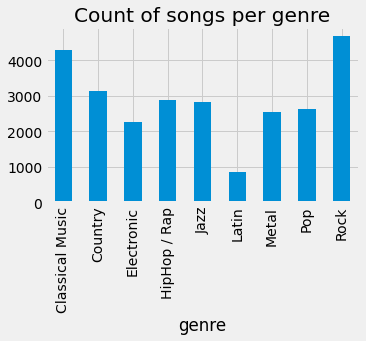

genre
Latin               841
Electronic         2266
Metal              2537
Pop                2628
Jazz               2831
HipHop / Rap       2872
Country            3131
Classical Music    4294
Rock               4690
dtype: int64


26090

In [ ]:
fig, ax = plt.subplots(ncols=1,figsize =(5, 3))
data.groupby('genre').size().plot(kind='bar')
plt.title('Count of songs per genre')
plt.show()

print(data.groupby('genre').size().sort_values())
len(data)

### Attribute Distribution

Now we will take a look at the attributes which describe the songs. These include the 9 attributes 'energy', 'liveness', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'valence', 'loudness' and "duration in miliseconds". 

The overall results are dominated by the genres with most songs. Most attributes are bounded by 0 and 1. Only 'loudness' and 'duration_ms' are on a different scale. We can see that some variables have a quite even distribution such as 'energy', 'danceability' and 'valence'. In  contrast there are variables that are quite left skewed such as 'liveness' and 'speechiness'.'duration_ms' is a not so extreme case of left-skewedness. The variables 'acousticness' and 'instrumentalness' seem to have a lot of values on both extreme ends. 'loudness' is pretty right skewed. 

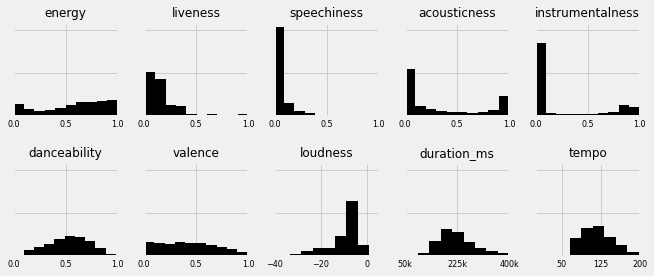

In [ ]:
data_01 = data[['energy', 'liveness', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'valence', 'loudness', "duration_ms", 'tempo', 'genre']]
n_columns = len(data_01.columns)-1
data_01["duration_ms"] = data_01[data_01["duration_ms"]<400000]["duration_ms"]   #filtering very long songs for better visualisation

fig1, ax1 = plt.subplots(sharey=True, ncols=round(n_columns/2), nrows=2, figsize =(10, 4))
#fig1.text(0.06, 0.4, 'Overall', va='center', rotation='vertical', size=16)
fig1.subplots_adjust(wspace=0.25, hspace=0.5)
for i in range(n_columns):
  axis = ax1[i//5, i % 5]
  if i==10: continue
  plt.setp(axis.get_yticklabels(), visible=False)
  data_01[data_01.columns[i]].hist(ax=axis, color="black")
  axis.set_title(data_01.columns[i], size=12)
  axis.tick_params(axis='x', which='major', labelsize=8)
  if data_01.columns[i] == "loudness":
    axis.set_xlim(-40,5)
    axis.set_xticks([-40, -20, 0])
  elif data_01.columns[i] == "duration_ms":
    axis.set_xlim(50000,400000)
    axis.set_xticks([50000, 225000, 400000])
    axis.set_xticklabels(["50k", "225k", "400k"])
  elif data_01.columns[i] == "tempo":
    axis.set_xlim(0,200)
    axis.set_xticks([50, 125, 200])
  else:
    axis.set_xlim(0,1)
    axis.set_xticks([0, 0.5, 1]) 

plt.show()

In this plot we can see the distribution of the variables grouped by their genre. Here we can detect even extremer distributions compared to the over all plots. Especially interesting are clear opposites can be detected in certain categories.

Examples:


*   Energy: classic & metal
*   Speechiness: classic & rap



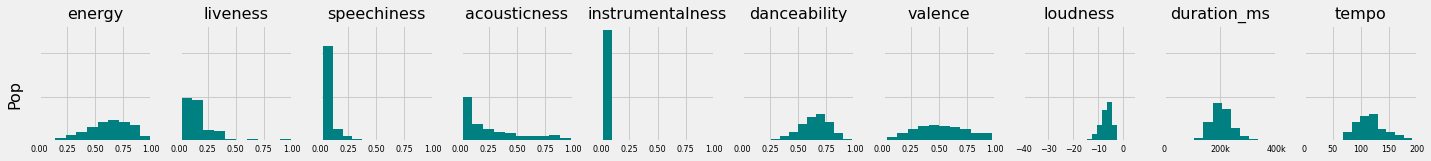

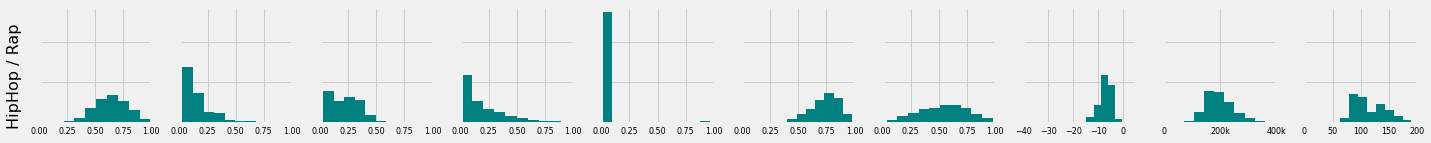

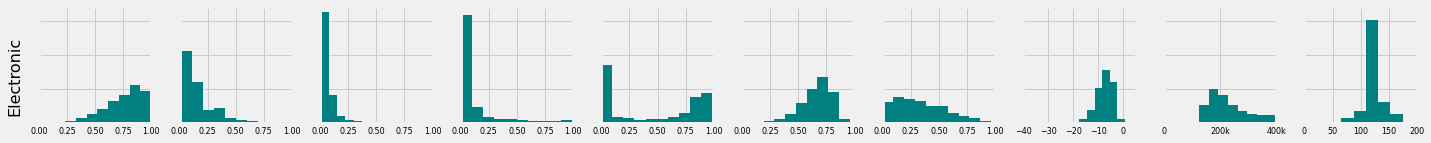

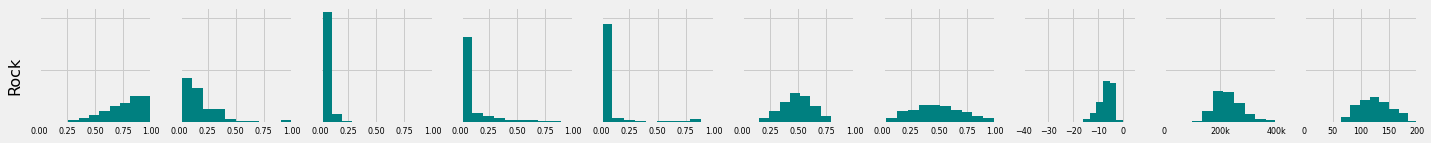

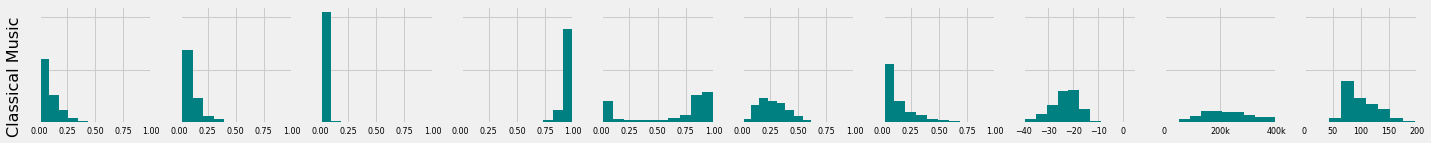

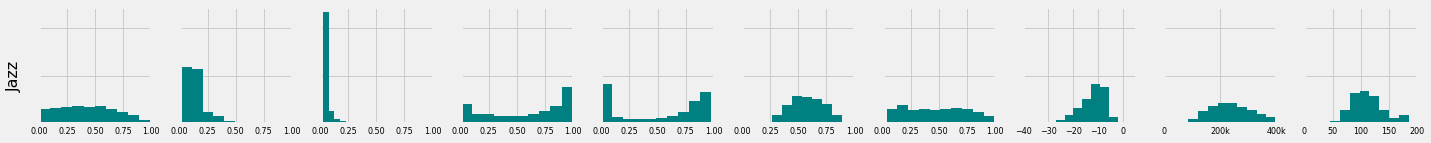

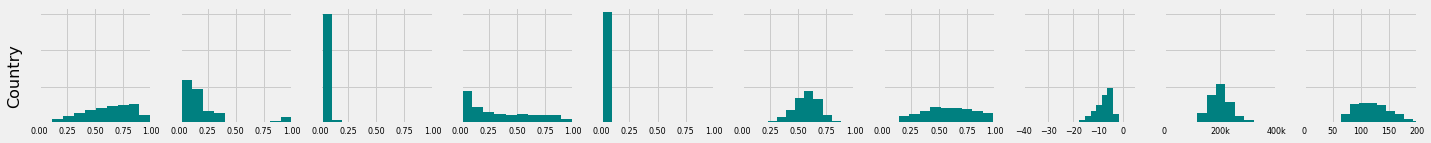

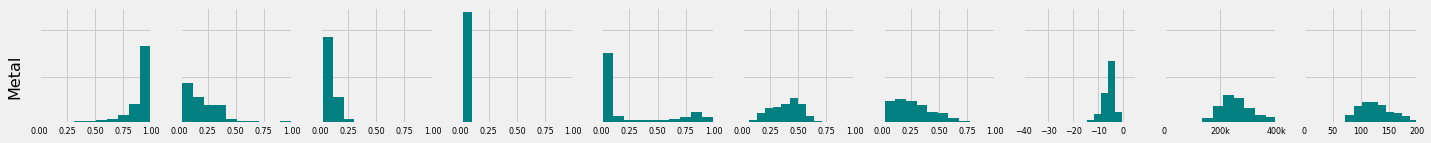

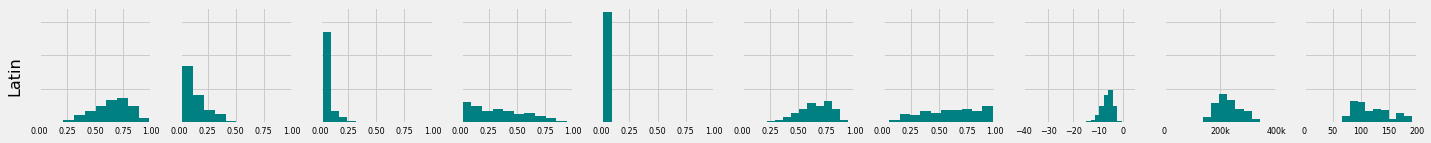

In [ ]:
firsttime = 0
for genre in data.genre.unique():
  fig, ax = plt.subplots(sharey=True, ncols=n_columns,figsize =(22, 2))
  fig.text(0.06, 0.4, genre, va='center', rotation='vertical', size=16)
  fig.subplots_adjust(wspace=0.25)
  for i in range(n_columns):
    axis = ax[i]
    if firsttime!=n_columns:
      axis.set_title(data_01.columns[i], size=16)
      firsttime+=1
    plt.setp(axis.get_yticklabels(), visible=False)
    data_01[data_01.columns[i]][data_01.genre==genre].hist(ax=axis, color="teal", bins=10)
    axis.tick_params(axis='x', which='major', labelsize=8)
    if data_01.columns[i] == "loudness":
      axis.set_xlim(-40,5)
      axis.set_xticks([-40, -30, -20, -10, 0])
    elif data_01.columns[i] == "duration_ms":
      axis.set_xlim(0,400000)
      axis.set_xticks([0, 200000, 400000])
      axis.set_xticklabels(["0", "200k", "400k"])
    elif data_01.columns[i] == "tempo":
      axis.set_xlim(0,200)
      axis.set_xticks([0, 50, 100, 150, 200])
    else:
      axis.set_xlim(0,1)
      axis.set_xticks([0, 0.25, 0.5, 0.75, 1]) 


## Explanation of Data

Are all attributes and their types listed?
Are attributes explained?

Fortunately, Spotify provides positive answers to those questions (even with examples and ranges of vars). 

- "id": str - Spotify-ID of the song - Can be ommited 
- "duration_ms": int | [0,inf] | duration of the song in ms
- "tempo": float | [0,inf] | The overall estimated tempo of a track in beats per minute (BPM)
- "time_signature": int | [3,7] | Estimated overall beats per bar of a track (dt. "Takt") (from 3/4 to 7/4)
- "loudness": float | [-inf,inf] | averaged loudness of a song in Dezibel (db) (typically between -60 and 0) 
- "key": int | [0,11] | the key the track is in (0=C, 1=C#, 2=D, ...)
- "mode": int | [0,1] | modality (major/minor) of the track (0=minor, 1=major)

- "danceability": float | [0,1] | how suitable a track is for dancing
- "energy": float | [0,1] | a perceptual measure of intensity and activity
- "speechiness": float | [0,1] | detects spoken words in a track (<0.33=music/songs | 0.33-0.66=music with spoken words like rap | >0.66=only spoken words like talkshow)
- "valence": float | [0,1] | - a perceptual measure of positiveness

- "acousticness": float | [0,1] | confidence measure whether the track is acoustic
- "instrumentalness": float | [0,1] | confidence measure whether the track has no vocals
-  "liveness": float | [0,1] | confidence measure whether the track was performed live


## Correlation

In order to understand the data better, we check for correlation within. With the (1) correlation matrix we get an overview over the correlation status. In (2) we take a closer look at highly correlated variables.

### (1) Correlation Matrix Plot
The following plot shows the correlation between each variable in the training data set of the x variables. Yellow-ish fields are not correlated while colors from orange to red are positively correlated and colors from green to blue are negatively correlated (the perfect correlation on the diagonal is not included in this color scheme).

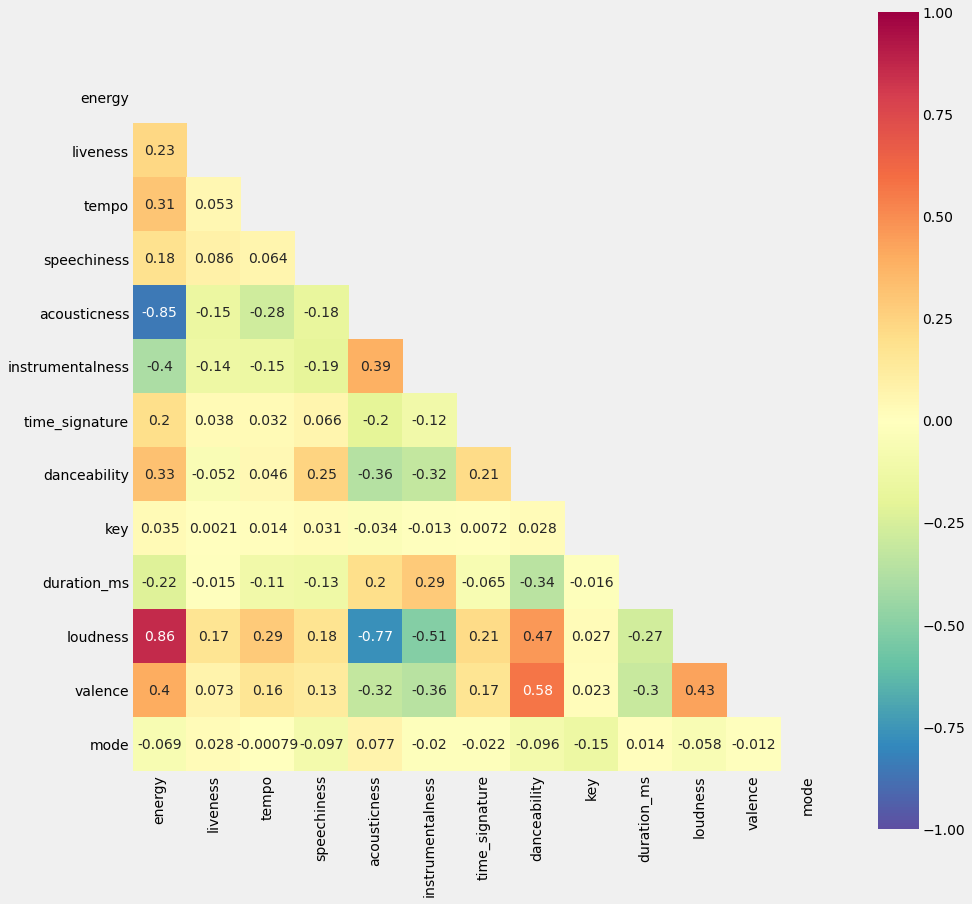

In [ ]:
# Correlation Analysis
corrs = data.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14, 14))
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-1, vmax=1, annot=True)

### (2) Highly correlated variables
In the following table we can see the variables that are higher correlated than 0.5. Loudness and energy have the highest correlation with about 0.86. Energy and acousticness have a correlation of -0.85, acousticness and loudness of -0.76. Other than that valence and danceability as well as instrumentalness and loudness have a correlation over 0.5 with 0.58 and -0.52. 

In [ ]:
corrs[(corrs > 0.5) | (corrs < -0.5)]

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
energy,1.000000,NaN,NaN,NaN,-0.850527,NaN,NaN,NaN,NaN,NaN,0.859656,NaN,NaN
liveness,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tempo,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speechiness,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,-0.850527,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,-0.768014,NaN,NaN
instrumentalness,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.514884,NaN,NaN
time_signature,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
danceability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.576597,NaN
key,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
duration_ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


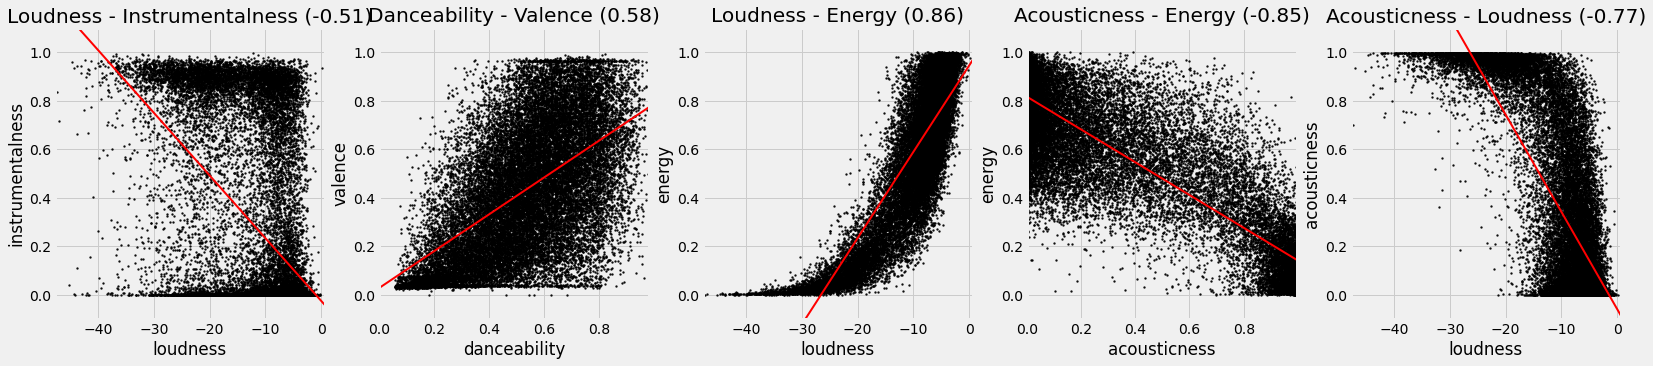

In [ ]:
fig, ax = plt.subplots(ncols = 5, figsize =(28, 5))

sns.regplot(x = data.loudness, y= data.instrumentalness, ci=None, scatter_kws={"color": "black", "s": 2}, line_kws={"color": "red", "linewidth": 2}, ax=ax[0])
ax[0].set_title('Loudness - Instrumentalness (' + str(round(corrs["loudness"]["instrumentalness"],2)) + ")")
ax[0].set_ylim(-0.1,1.1)

sns.regplot(x = data.danceability, y= data.valence, ci=None, scatter_kws={"color": "black", "s": 2}, line_kws={"color": "red", "linewidth": 2}, ax=ax[1])
ax[1].set_title('Danceability - Valence (' + str(round(corrs["danceability"]["valence"],2)) + ")")
ax[1].set_ylim(-0.1,1.1)

sns.regplot(x = data.loudness, y= data.energy, ci=None, scatter_kws={"color": "black", "s": 2}, line_kws={"color": "red", "linewidth": 2}, ax=ax[2])
ax[2].set_title('Loudness - Energy (' + str(round(corrs["loudness"]["energy"],2)) + ")")
ax[2].set_ylim(-0.1,1.1)

sns.regplot(x = data.acousticness, y= data.energy, ci=None, scatter_kws={"color": "black", "s": 2}, line_kws={"color": "red", "linewidth": 2}, ax=ax[3])
ax[3].set_title('Acousticness - Energy (' + str(round(corrs["acousticness"]["energy"],2)) + ")")
ax[3].set_ylim(-0.1,1.1)

sns.regplot(x = data.loudness, y= data.acousticness, ci=None, scatter_kws={"color": "black", "s": 2}, line_kws={"color": "red", "linewidth": 2}, ax=ax[4])
ax[4].set_title('Acousticness - Loudness (' + str(round(corrs["acousticness"]["loudness"],2)) + ")")
ax[4].set_ylim(-0.1,1.1)

plt.show()

Check for p-values (significance of correlation)

In [ ]:
print('Loudness & Instrumentalness corrcoef & p-value', pearsonr(data.loudness, data.instrumentalness))
print('Danceability & Valence corrcoef , p-value' , pearsonr(data.danceability, data.valence))
print('Loudness & Energy corrcoef , p-value' , pearsonr(data.loudness, data.energy))
print('Acousticness & Engery corrcoef , p-value' , pearsonr(data.acousticness, data.energy))
print('Acousticness & Loudness corrcoef , p-value' , pearsonr(data.loudness, data.acousticness))

Loudness & Instrumentalness corrcoef & p-value (-0.5148844239662985, 0.0)
Danceability & Valence corrcoef , p-value (0.576597409099614, 0.0)
Loudness & Energy corrcoef , p-value (0.8596562612291785, 0.0)
Acousticness & Engery corrcoef , p-value (-0.8505273961773994, 0.0)
Acousticness & Loudness corrcoef , p-value (-0.7680139956654919, 0.0)


## Quality of Data

Overall, the quality of the data is good. There are a few missing values (no response from the API), many duplicates and other documented steps in the notebook in order to prepare the data for the models. But in general the quality is sufficient to put it in a model.

# Pipeline 2

Although values of speechiness can reach from 0 to 1, Spotify says, that for speechiness 

"*values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.*"

Therefor we consider tracks with an speechiness value of >0.66 as not in the predefined interval.

As not all values fall in predefined intervals, we have to check for this invalidity and filter invalid tracks.

In [ ]:
for ts in data["time_signature"].unique():
  if ts not in [1,3,4,5,6,7]:
    print("{} tracks have time_signature of {}, which is not a valid time_signature. These tracks are filtered.".format(len(data[data["time_signature"]==ts]), ts))
    data = data[data["time_signature"]!=ts]

print("{} tracks have speechiness of >0.66, which is not a valid speechiness value. These tracks are filtered.".format(len(data[data["speechiness"]>0.66])))
data = data[data["speechiness"]<=0.66]

4 tracks have time_signature of 0.0, which is not a valid time_signature. These tracks are filtered.
60 tracks have speechiness of >0.66, which is not a valid speechiness value. These tracks are filtered.


## Train-Test-Split
It is important to preprocessing only on Train data, as the test data and its distribution shouldn't be known by the classifier beforehand. Therefore we implement our stratified Train-Test-Split here.

In [ ]:
# Train Test Split
X = data.drop(["genre", "playlist_id", "track_id"], axis=1)
Y = data["genre"]

X["mode"] = X["mode"].astype('category')
X["time_signature"] = X["time_signature"].astype('category')
X["key"] = X["key"].astype('category')

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, random_state=42)
print(len(x_train), len(x_test), len(y_train), len(y_test))

19519 6507 19519 6507


##Outlier Detection & Handling
Outliers need to be detected and handled. As the data is from the Spotify API and we filtered invalid data, all rows represent real tracks, what most probably makes our outliers not errors of some kind but suprisingly correct values. Therefore it's quite hard to deal with those.

There are 3 options how to deal with outliers:
- Removing
- Clipping / Winsorizing (change them, so they are in a "normal" range)
- Retaining


The Problem with removing is, that we loose a lot of information and change the distribution of a feature. Therefore, it is often proposed to retain them and use classifiers or scaling which can handle outliers.

Thats why our 2 Option we consider are clipping and retaining.

Number of Outliers per Feature: 
energy                 0
liveness            1493
tempo                 29
speechiness         2458
acousticness           0
instrumentalness       0
danceability           0
duration_ms         1532
loudness            1552
valence                0
dtype: int64



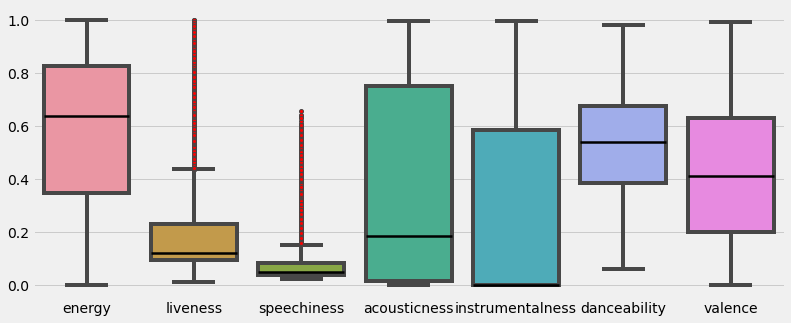

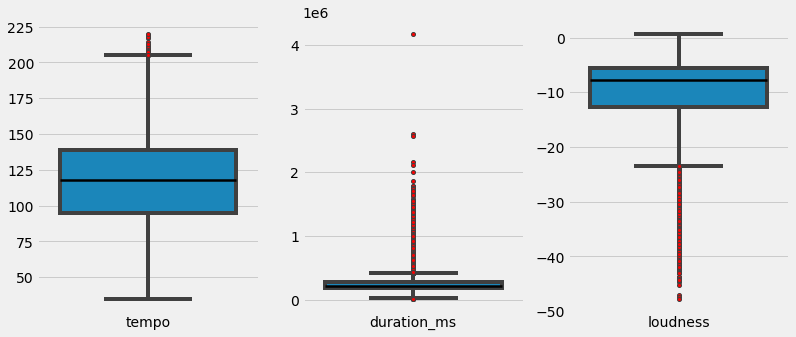

In [ ]:
print("Number of Outliers per Feature: ")
x = x_train[['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']]
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1
print(((x < (Q1 - 1.5 * IQR)) | (x > (Q3 + 1.5 * IQR))).sum())

print()

flierprops = dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none')
medianprops = dict(linewidth=2.5, color='black')
fig, ax = plt.subplots(ncols=1, figsize=(12, 5)) 
sns.boxplot(data=data[["energy","liveness","speechiness", "acousticness","instrumentalness","danceability","valence"]], ax=ax, flierprops=flierprops, medianprops=medianprops)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5)) 
sns.boxplot(data=data[["tempo"]], ax=ax1, flierprops=flierprops, medianprops=medianprops)
sns.boxplot(data=data[["duration_ms"]], ax=ax2, flierprops=flierprops, medianprops=medianprops)
sns.boxplot(data=data[["loudness"]], ax=ax3, flierprops=flierprops, medianprops=medianprops)
plt.show()

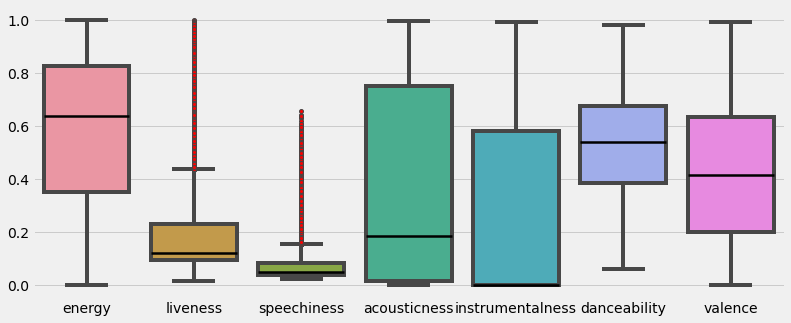

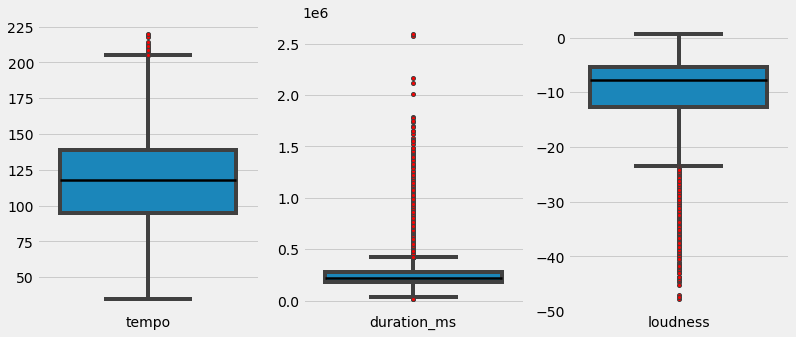

In [ ]:
if OUTLIER_HANDLING == "ClippingIQR":
  for column in ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']:
    Q1 = x_train[column].quantile(0.25)
    Q3 = x_train[column].quantile(0.75)
    IQR = Q3 - Q1
    floor, ceil = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    x_train[column].clip(floor, ceil, inplace=True)
elif OUTLIER_HANDLING == "Clipping5%Percentile":
  for column in ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']:
    floor, ceil = x_train[column].quantile(0.95), x_train[column].quantile(0.05)
    x_train[column].clip(floor, ceil, inplace=True)
  outliers3 = x.clip(lower=x.quantile(0.03), upper=x.quantile(0.97), axis=1)

fig, ax = plt.subplots(ncols=1, figsize=(12, 5)) 
sns.boxplot(data=x_train[["energy","liveness","speechiness", "acousticness","instrumentalness","danceability","valence"]], ax=ax, flierprops=flierprops, medianprops=medianprops)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5)) 
sns.boxplot(data=x_train[["tempo"]], ax=ax1, flierprops=flierprops, medianprops=medianprops)
sns.boxplot(data=x_train[["duration_ms"]], ax=ax2, flierprops=flierprops, medianprops=medianprops)
sns.boxplot(data=x_train[["loudness"]], ax=ax3, flierprops=flierprops, medianprops=medianprops)
plt.show()


## Feature Scaling
Feature Scaling is important for all distance-based estimators in order to bring all features to the same scale. This prevents features with a very big scale from domination of features with a small scale. 
- MinMaxScaler
- StandardScaler
- RobustScaler

With regards to Scaling, it is also important to be aware of and handle outliers, as they heavily influence the result for some Scalers. 


### Visualize different Scalers

**Notes:**
- *The original data isn't plotted, as one can't see any lines because of the different scales*
- *For every Scaler except MinMaxScaler, we zoomed on the same area to make it comparable*

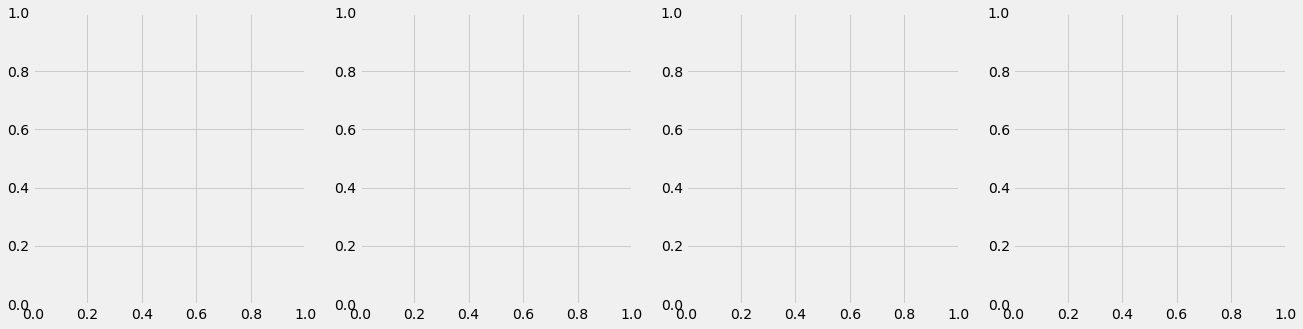

In [ ]:
numerical = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']
categorical = ['mode', 'time_signature', 'key']
colors = ["red", "blue", "brown", "pink", "purple", "orange", "yellow", "gray", "black", "green"]
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), QuantileTransformer(output_distribution='normal')]
scalers_name = ["MinMaxScaler", "StandardScaler", "RobustScaler", "QuantileTransformer"]
fig, ax = plt.subplots(ncols = 4, figsize =(20, 5))
x = x_train[numerical]

for i in range(len(scalers)):
  axis = ax[i]
  scaled_x = pd.DataFrame(scalers[i].fit_transform(x), columns=numerical) 
  axis.set_xlabel("Scale")
  axis.set_title(scalers_name[i])
  if i>0: axis.set_xlim(-7,7)
  for j in range(len(numerical)):
    sns.kdeplot(scaled_x[numerical[j]], ax = axis, color=colors[j], linewidth=2) 

plt.show()

### Apply Scaling

In [ ]:
if SCALING=="RobustScaling": scaler = RobustScaler()
elif SCALING =="StandardScaling": scaler = StandardScaler()
elif SCALING =="MinMaxScaling": scaler = MinMaxScaler()

if SCALING!="NoScaling":
  scaler = scaler.fit(x_train[numerical])
  x_train[numerical] = scaler.transform(x_train[numerical])
  x_test[numerical] = scaler.transform(x_test[numerical])

  # Save scaler for scaling of new data in production use
  result_folder = "/content/drive/My Drive/Spotify Song Classification/data/results/"
  Path(result_folder).mkdir(parents=True, exist_ok=True)
  with open(result_folder+"robust_scaler.obj", "wb") as f:
    pickle.dump(scaler, f)
  print(SCALING, scaler)

RobustScaling RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)


In [ ]:
x_train

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
3701,-0.203354,0.664234,0.572348,9.586652,-0.085691,-0.001236,4.0,0.717241,1.0,-0.632508,-0.191243,0.177011,1.0
17326,-0.526205,-0.229197,-0.698043,-0.256189,0.923558,0.078107,4.0,0.265517,11.0,-1.084223,-0.459649,-0.521839,0.0
17094,-0.706499,-0.194161,-1.084941,0.230355,0.999728,0.372944,4.0,-0.672414,4.0,1.520427,-1.358823,-0.213793,1.0
5069,0.190776,-0.124088,0.272873,0.290635,-0.168934,-0.002272,4.0,1.168966,7.0,0.156632,0.341683,-0.179310,0.0
3227,-0.014675,-0.116788,-0.247878,0.286329,0.414853,-0.002052,4.0,1.482759,6.0,-0.772900,0.061481,0.554023,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15375,-1.000000,0.751825,-1.036086,-0.107643,0.491023,-0.002052,4.0,-0.241379,0.0,-0.710033,-0.666713,-0.078161,1.0
5936,0.633124,0.197080,-0.125310,0.488698,-0.124048,0.004200,3.0,-0.617241,10.0,-0.673207,0.466033,-0.195402,0.0
16572,-1.309853,-0.058394,-1.210319,-0.157158,1.086779,1.607026,4.0,-1.282759,5.0,-0.276408,-3.236417,-0.850575,0.0
15292,-1.306918,-0.168613,-0.493355,0.064586,1.088139,1.515804,3.0,-1.027586,2.0,0.088465,-3.046007,-0.409195,1.0


## Binning

In [ ]:
if BINNING:
  for i in range(len(numerical)):
    column = numerical[i]
    bin_border = [float("-inf")]
    for i in range(1,BINNING):
      bin_border.append(x_train[column].quantile((i)/BINNING))
    bin_border.append(float("inf"))
    #print("{}:\n  {}".format(column, bin_border))
    x_train[column] = pd.cut(x_train[column], bins=bin_border, precision=8, duplicates="drop", labels=False)
    x_test[column] = pd.cut(x_test[column], bins=bin_border, precision=8, duplicates="drop", labels=False)
    x_train[column] = x_train[column].astype('category')
    x_test[column] = x_test[column].astype('category')

## Encoding of Categorical Features


In [ ]:
x_train = pd.get_dummies(x_train, columns=categorical, prefix=["IsMode", "IsTimeSig", "IsKey"])
x_test = pd.get_dummies(x_test, columns=categorical, prefix=["IsMode", "IsTimeSig", "IsKey"])
x_train

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,IsMode_0.0,IsMode_1.0,IsTimeSig_1.0,IsTimeSig_3.0,IsTimeSig_4.0,IsTimeSig_5.0,IsKey_0.0,IsKey_1.0,IsKey_2.0,IsKey_3.0,IsKey_4.0,IsKey_5.0,IsKey_6.0,IsKey_7.0,IsKey_8.0,IsKey_9.0,IsKey_10.0,IsKey_11.0
3701,3,7,7,9,4,3,8,1,3,5,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
17326,2,2,1,2,7,5,6,0,3,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
17094,2,2,0,6,8,5,1,8,1,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5069,6,3,6,6,3,0,9,5,7,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3227,4,3,3,6,6,3,9,0,5,7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15375,1,7,0,3,6,3,3,0,2,4,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5936,9,6,4,6,4,4,2,1,8,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16572,0,4,0,3,9,8,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
15292,0,2,2,5,9,7,1,5,0,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Feature Selection (with Select Percentile)


In [ ]:
if FEATURE_SELECTION:
  # create selector
  selector = SelectPercentile(score_func=f_classif, percentile=FEATURE_SELECTION)

  # apply
  selector = selector.fit(x_train, y_train)
  new_x_train = selector.transform(x_train)
  new_x_test = selector.transform(x_test)

  # get columns that are included in best
  selector.get_support(indices=True)
  colNames = x_train.columns.values[selector.get_support()].tolist()
  print(colNames)

  x_train = pd.DataFrame(data=new_x_train, columns=colNames)
  x_test = pd.DataFrame(data=new_x_test, columns=colNames)

['energy', 'acousticness', 'instrumentalness', 'danceability', 'loudness', 'valence']


## Store Result

In [ ]:
# result storage
Path("/content/drive/My Drive/Spotify Song Classification/data/preprocessed/" + DATASET_NAME).mkdir(parents=True, exist_ok=True)

x_train.to_csv("/content/drive/My Drive/Spotify Song Classification/data/preprocessed/"+ DATASET_NAME +"/x_train.csv")
y_train.to_csv("/content/drive/My Drive/Spotify Song Classification/data/preprocessed/"+ DATASET_NAME +"/y_train.csv")
x_test.to_csv("/content/drive/My Drive/Spotify Song Classification/data/preprocessed/"+ DATASET_NAME +"/x_test.csv")
y_test.to_csv("/content/drive/My Drive/Spotify Song Classification/data/preprocessed/"+ DATASET_NAME +"/y_test.csv")